# **Data importation**

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!chmod 600 kaggle.json

In [ ]:
!kaggle competitions download -c sentiment-analysis-on-movie-reviews

  0% 0.00/494k [00:00<?, ?B/s]
100% 494k/494k [00:00<00:00, 13.2MB/s]
  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 38.2MB/s]
  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 63.1MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

Archive:  test.tsv.zip
  inflating: test.tsv                

Archive:  train.tsv.zip
  inflating: train.tsv               

2 archives were successfully processed.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import re
from sklearn.preprocessing import LabelEncoder

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# **Data preprocessing**

In [ ]:
tr = pd.read_csv('/content/train.tsv',sep='\t')

In [ ]:
print(tr.shape)
tr.head(3)

(156060, 4)


PhraseId  ...  Sentiment
0         1  ...          1
1         2  ...          2
2         3  ...          2

[3 rows x 4 columns]

In [ ]:
print(tr['Phrase'].iloc[0])
print('+++++++')
print(tr['Phrase'].iloc[1])

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
+++++++
A series of escapades demonstrating the adage that what is good for the goose


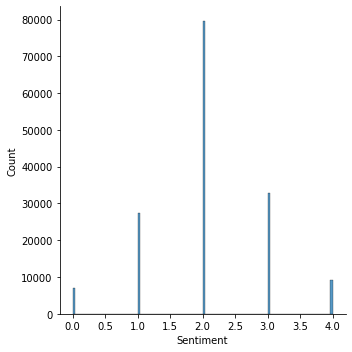

In [ ]:
sns.displot(tr['Sentiment'])

- We can see that our data is imbalanced.

- Our goal is not to submit the result on the Kaggle competition but to apply some DL models to compare their results and performance in order to merge the classes and keep only 3 classes to reduce the difference of the classes in terms of number of samples.
- 0, 1 : negative (0)
- 2 : neutre (1)
- 3, 4 : positive (2) 

In [ ]:
tr['Sentiment']=tr['Sentiment'].replace({1:0})

In [ ]:
tr['Sentiment']=tr['Sentiment'].replace({2:1})

In [ ]:
tr['Sentiment']=tr['Sentiment'].replace({3:2,4:2})

- The new distribution

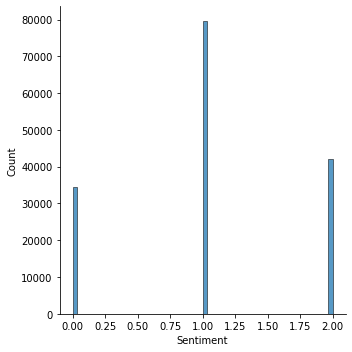

In [ ]:
sns.displot(tr['Sentiment'])

- We won't change the text data much, just small changes to clean up the data.

In [ ]:
def text_preprocessing(s):
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()   
    return s

In [ ]:
tr['clean_text'] = tr['Phrase'].apply(text_preprocessing)

# **Splitting Data**

In [ ]:
X = tr['clean_text']
#Y = tr['Sentiment'].values
Y = pd.get_dummies(tr['Sentiment']).values
x_tr,x_val,y_tr,y_val = train_test_split(X,Y,test_size=0.2,random_state=42,stratify=tr['Sentiment'])

# **Tokenization**

- For the evaluation, we will use the F1 score and the ROC AUC curve. We will use classification report method to get more details.

In [ ]:
#print(classification_report(y_test, y_pred, target_names=labels))

- For RNN, LSTM and GRU models we need to tokenize our data. For Transformers, they have their tokenizers

- **Tokenization**

In [ ]:
tr['len'] = tr['clean_text'].apply(len)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Tocken count')

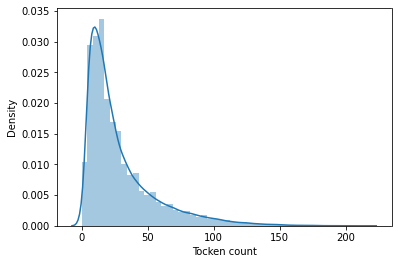

In [ ]:
sns.distplot(tr['len'])
plt.xlabel('Tocken count')

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
np.random.seed(1000)
num_most_freq_words_to_include = 5000
MAX_REVIEW_LENGTH_FOR_KERAS_RNN = 150
embedding_vector_length = 32

In [ ]:
tr_list = x_tr.tolist()
val_list = x_val.tolist()
all_list = x_tr.tolist() + x_val.tolist()

In [ ]:
tokenizer = Tokenizer(num_words=num_most_freq_words_to_include)
tokenizer.fit_on_texts(all_list)

In [ ]:
tr_tokenized = tokenizer.texts_to_sequences(tr_list)
x_train = pad_sequences(tr_tokenized, maxlen=MAX_REVIEW_LENGTH_FOR_KERAS_RNN)
val_tokenized = tokenizer.texts_to_sequences(val_list)
x_val = pad_sequences(val_tokenized, maxlen=MAX_REVIEW_LENGTH_FOR_KERAS_RNN)

In [ ]:
x_train.shape

(124848, 150)

In [ ]:
tokenizer.num_words

5000

# **RNN_LSTM_GRU**

- We will use CNN layers in our models because they are powerful for extracting information from text.

- **RNN**

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input,LSTM, Dense, Dropout, Masking,Conv1D, MaxPool1D, GRU, Embedding,SimpleRNN

In [ ]:
def rnn_model(use_cnn = False, use_lstm = False,use_gru = False):
    input_sequences = Input(shape = (MAX_REVIEW_LENGTH_FOR_KERAS_RNN,))
    initial_dropout = 0.2
    embedding_layer = Embedding(input_dim = num_most_freq_words_to_include, 
                                output_dim = embedding_vector_length,
                                input_length = MAX_REVIEW_LENGTH_FOR_KERAS_RNN)
    X = embedding_layer(input_sequences)
    X = Dropout(0.2)(X)
    if use_cnn:
        X = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(X)
        X = MaxPool1D(pool_size=2)(X)
        
    # Add RNN,GRU or LSTM layers
    dropout_W = 0.2
    dropout_U = 0.2
    
    if use_lstm:
        X = LSTM(100, dropout = dropout_W, recurrent_dropout = dropout_U)(X)
    elif use_gru:
        X = GRU(100, dropout=dropout_W, recurrent_dropout=dropout_U)(X)
    else:
        X = SimpleRNN(100, dropout=dropout_W, recurrent_dropout=dropout_U)(X)
    X = Dropout(0.2)(X)
    outputs= Dense(3, activation='softmax')(X)
    model = Model(inputs = input_sequences, outputs = outputs)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
rnn_model1 = rnn_model()

In [ ]:
rnn_model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 150, 32)           160000    
                                                                 
 dropout_4 (Dropout)         (None, 150, 32)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               13300     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 173,603
Trainable params: 173,603
Non-trainab

In [ ]:
rnn_model1.fit(x_train, y_tr, batch_size=512, epochs=5, validation_data=[x_val, y_val])

Epoch 1/5
244/244 [==============================] - 89s 359ms/step - loss: 1.0115 - accuracy: 0.5082 - val_loss: 0.8835 - val_accuracy: 0.6075
Epoch 2/5
244/244 [==============================] - 114s 469ms/step - loss: 0.8130 - accuracy: 0.6559 - val_loss: 0.7396 - val_accuracy: 0.6944
Epoch 3/5
244/244 [==============================] - 102s 418ms/step - loss: 0.7337 - accuracy: 0.7000 - val_loss: 0.7175 - val_accuracy: 0.7061
Epoch 4/5
244/244 [==============================] - 106s 432ms/step - loss: 0.7079 - accuracy: 0.7121 - val_loss: 0.7101 - val_accuracy: 0.7128
Epoch 5/5
244/244 [==============================] - 90s 368ms/step - loss: 0.6931 - accuracy: 0.7190 - val_loss: 0.7124 - val_accuracy: 0.7125


- The model performance increases slowly maybe because of the disappearing issue, that's why we will try LSTM and GRU which solve this issue.

- **LSTM**

In [ ]:
lstm_model = rnn_model(use_lstm = True)

In [ ]:
lstm_model.fit(x_train, y_tr, batch_size=512, epochs=5, validation_data=[x_val, y_val])

Epoch 1/5
244/244 [==============================] - 220s 889ms/step - loss: 0.8811 - accuracy: 0.6053 - val_loss: 0.7377 - val_accuracy: 0.6966
Epoch 2/5
244/244 [==============================] - 274s 1s/step - loss: 0.7182 - accuracy: 0.7082 - val_loss: 0.7110 - val_accuracy: 0.7112
Epoch 3/5
244/244 [==============================] - 285s 1s/step - loss: 0.6919 - accuracy: 0.7199 - val_loss: 0.7027 - val_accuracy: 0.7124
Epoch 4/5
244/244 [==============================] - 216s 884ms/step - loss: 0.6803 - accuracy: 0.7249 - val_loss: 0.7009 - val_accuracy: 0.7160
Epoch 5/5
244/244 [==============================] - 212s 867ms/step - loss: 0.6713 - accuracy: 0.7280 - val_loss: 0.6956 - val_accuracy: 0.7182


- **GRU**

In [ ]:
gru_model = rnn_model(use_gru=True)

In [ ]:
gru_model.fit(x_train, y_tr, batch_size=512, epochs=5, validation_data=[x_val, y_val])

Epoch 1/5
244/244 [==============================] - 209s 846ms/step - loss: 0.8818 - accuracy: 0.6040 - val_loss: 0.7383 - val_accuracy: 0.6975
Epoch 2/5
244/244 [==============================] - 192s 787ms/step - loss: 0.7215 - accuracy: 0.7071 - val_loss: 0.7093 - val_accuracy: 0.7115
Epoch 3/5
244/244 [==============================] - 191s 782ms/step - loss: 0.6953 - accuracy: 0.7176 - val_loss: 0.7050 - val_accuracy: 0.7131
Epoch 4/5
244/244 [==============================] - 193s 790ms/step - loss: 0.6814 - accuracy: 0.7230 - val_loss: 0.6959 - val_accuracy: 0.7166
Epoch 5/5
244/244 [==============================] - 192s 786ms/step - loss: 0.6700 - accuracy: 0.7274 - val_loss: 0.6921 - val_accuracy: 0.7180


# **Seq2Seq**

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import *
from tensorflow.keras.initializers import *
import tensorflow as tf

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
np.random.seed(1000)
num_most_freq_words_to_include = 5000
MAX_REVIEW_LENGTH_FOR_KERAS_RNN = 150

In [ ]:
tr_list = x_tr.tolist()
val_list = x_val.tolist()
all_list = x_tr.tolist() + x_val.tolist()

In [ ]:
tokenizer = Tokenizer(num_words=num_most_freq_words_to_include)
tokenizer.fit_on_texts(all_list)

In [ ]:
tr_tokenized = tokenizer.texts_to_sequences(tr_list)
x_train = pad_sequences(tr_tokenized, maxlen=MAX_REVIEW_LENGTH_FOR_KERAS_RNN)
val_tokenized = tokenizer.texts_to_sequences(val_list)
x_val = pad_sequences(val_tokenized, maxlen=MAX_REVIEW_LENGTH_FOR_KERAS_RNN)

In [ ]:
x_train.shape

(124848, 150)

In [ ]:
batch_size = 512  # Batch size for training.
epochs = 10  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = x_train.shape[0]  # Number of samples to train on.

In [ ]:
num_encoder_tokens = x_train.shape[1]
num_decoder_tokens = 3

In [ ]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax') ##
decoder_outputs = decoder_dense(decoder_outputs)
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 150)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 256),        416768      ['input_3[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [ ]:
# Run training
from tensorflow.keras.optimizers import Adam
model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#Resize inputs to be compatible with our model
x_train1 = x_train.reshape((x_train.shape[0],None,x_train.shape[1]))
x_val1 = x_val.reshape((x_val.shape[0],None,x_val.shape[1]))
print(x_train.shape)
print(x_train1.shape)

TypeError: ignored

In [ ]:
model.fit([x_train1, x_train1], y_tr,
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=[x_val1,y_val])

Epoch 1/10


ValueError: ignored

# **Transformers**

In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

In [ ]:
import tensorflow as tf
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
import warnings
warnings.simplefilter('ignore')

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input,LSTM, Dense, Dropout, Masking,Conv1D, MaxPool1D, GRU, Embedding,SimpleRNN

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader, Dataset

In [ ]:
import random
import os
SEED = 34
def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
random_seed(SEED)

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# **Bert**

In [ ]:
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing

In [ ]:
# Tokenizing the combined text data using bert tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [ ]:
def bert_encode(texts, tokenizer, max_len=150):
    all_tokens = []
    all_masks = []
    all_segments = []
    for text in texts:
        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=True)

In [ ]:
#Build The Model
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    clf_output = sequence_output[:, 0, :]
    
    lay = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    lay = tf.keras.layers.Dense(32, activation='relu')(lay)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    out = tf.keras.layers.Dense(3, activation='softmax')(lay)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
max_len = 150
train_input = bert_encode(x_tr, tokenizer, max_len=max_len)
val_input = bert_encode(x_val, tokenizer, max_len=max_len)
train_labels = y_tr
val_labels = y_val

In [ ]:
model_bert = build_model(bert_layer, max_len=max_len)
model_bert.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 150)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 150)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 150)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 150, 768)]                'input_mask[0][0]',       

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=1)

In [ ]:
train_sh = model_bert.fit(
    train_input, train_labels,
    validation_data=[val_input,val_labels],
    epochs=3,
    callbacks=[earlystopping],
    batch_size=128,
    verbose=1
)

InternalError: ignored

In [ ]:
#this error disappear when we reduced the batch_size

# **XLNET**

In [ ]:
#!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.1 MB/s 


In [ ]:
from transformers import TFXLNetModel, XLNetTokenizer
xlnet_model = 'xlnet-base-cased'
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model)

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [ ]:
def create_xlnet(mname):
    """ Creates the model. It is composed of the XLNet main block and then a classification head its added
    """
    # Define token ids as inputs
    word_inputs = tf.keras.Input(shape=(150,), name='word_inputs', dtype='int32')
    # Call XLNet model
    xlnet = TFXLNetModel.from_pretrained(mname)
    xlnet_encodings = xlnet(word_inputs)[0]
    # CLASSIFICATION HEAD 
    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    # Apply dropout for regularization
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
    # Final output 
    outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(doc_encoding)
    # Compile model
    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
xlnet_model1 = create_xlnet(xlnet_model)

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


In [ ]:
xlnet_model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_inputs (InputLayer)    [(None, 150)]             0         
                                                                 
 tfxl_net_model_2 (TFXLNetMo  TFXLNetModelOutput(last_  116718336
 del)                        hidden_state=(None, 150,            
                              768),                              
                              mems=((150, None, 768),            
                              (150, None, 768),                  
                              (150, None, 768),                  
                              (150, None, 768),                  
                              (150, None, 768),                  
                              (150, None, 768),                  
                              (150, None, 768),                  
                              (150, None, 768),            

In [ ]:
def get_inputs(tweets, tokenizer, max_len=150):
    """ Gets tensors from text using the tokenizer provided"""
    inps = [tokenizer.encode_plus(t, max_length=max_len, pad_to_max_length=True, add_special_tokens=True) for t in tweets]
    inp_tok = np.array([a['input_ids'] for a in inps])
    ids = np.array([a['attention_mask'] for a in inps])
    segments = np.array([a['token_type_ids'] for a in inps])
    return inp_tok, ids, segments

def warmup(epoch, lr):
    """Used for increasing the learning rate slowly, this tends to achieve better convergence.
    However, as we are finetuning for few epoch it's not crucial.
    """
    return max(lr +1e-6, 2e-5)

In [ ]:
inp_tok_tr, ids_tr, segments_tr = get_inputs(x_tr, xlnet_tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
inp_tok_val, ids_val, segments_val = get_inputs(x_val, xlnet_tokenizer) 

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.02, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(warmup, verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1e-6, patience=2, verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-6)
]

In [ ]:
#Fitting
hist = xlnet_model1.fit(x=inp_tok_tr, y=y_tr, epochs=2, batch_size=16, validation_data=[inp_tok_val, y_val], callbacks=callbacks)

Epoch 1/2
1470/7803 [====>.........................] - ETA: 2:18:40 - loss: 1.1057 - accuracy: 0.4584

- To orient the model to our data, we need to specify the output layers so that they capture useful information from our data in order to scale the performance of our model.

In [ ]:
from tensorflow.keras.layers import Flatten
def create_xlnet2(mname):
    word_inputs = tf.keras.Input(shape=(150,), name='word_inputs', dtype='int32')
    xlnet = TFXLNetModel.from_pretrained(mname)
    xlnet_encodings = xlnet(word_inputs)[0]
    # CLASSIFICATION HEAD 
    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    # Apply dropout for regularization
    #doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
    #Add some dense and dropout layers here
    #
    top_model = Flatten(name="flatten")(doc_encoding)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(256,activation='relu')(top_model)
    #
    # Final output 
    #outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(doc_encoding)
    outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(top_model)
    # Compile model
    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
xlnet_model2 = create_xlnet2(xlnet_model)

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


In [ ]:
xlnet_model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_inputs (InputLayer)    [(None, 150)]             0         
                                                                 
 tfxl_net_model_1 (TFXLNetMo  TFXLNetModelOutput(last_  116718336
 del)                        hidden_state=(None, 150,            
                              768),                              
                              mems=((150, None, 768),            
                              (150, None, 768),                  
                              (150, None, 768),                  
                              (150, None, 768),                  
                              (150, None, 768),                  
                              (150, None, 768),                  
                              (150, None, 768),                  
                              (150, None, 768),              

In [ ]:
#Fitting
hist2 = xlnet_model2.fit(x=inp_tok_tr, y=y_tr, epochs=1, batch_size=32, validation_data=[inp_tok_val, y_val], callbacks=callbacks)

3902/3902 [==============================] - 6032s 2s/step - loss: 0.8245 - accuracy: 0.6348 - val_loss: 0.6703 - val_accuracy: 0.7050 - lr: 2.1000e-05


- **Trainable XLNET**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten, Dropout

In [ ]:
def create_xlnet3(mname):
    word_inputs = tf.keras.Input(shape=(150,), name='word_inputs', dtype='int32')
    xlnet = TFXLNetModel.from_pretrained(mname)
    #
    #
    for layer in xlnet.layers:
      layer.trainable = False
    #
    #
    xlnet_encodings = xlnet(word_inputs)[0]
    # CLASSIFICATION HEAD 
    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    # Apply dropout for regularization
    #doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
    #Add some dense and dropout layers here
    #
    top_model = Flatten(name="flatten")(doc_encoding)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(256,activation='relu')(top_model)
    #
    # Final output 
    #outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(doc_encoding)
    outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(top_model)
    # Compile model
    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
xlnet_model3 = create_xlnet3(xlnet_model)

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


In [ ]:
xlnet_model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_inputs (InputLayer)    [(None, 150)]             0         
                                                                 
 tfxl_net_model (TFXLNetMode  TFXLNetModelOutput(last_  116718336
 l)                          hidden_state=(None, 150,            
                              768),                              
                              mems=((150, None, 768),            
                              (150, None, 768),                  
                              (150, None, 768),                  
                              (150, None, 768),                  
                              (150, None, 768),                  
                              (150, None, 768),                  
                              (150, None, 768),                  
                              (150, None, 768),              

# **DistilBERT**

In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen) #max_length
    all_ids = []
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])  
    return np.array(all_ids)

In [ ]:
def build_model(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(3, activation='softmax')(cls_token)  
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy']) 
    return model

In [ ]:
# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 150

In [ ]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [ ]:
x_train_d = fast_encode(x_tr.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid_d = fast_encode(x_val.astype(str), fast_tokenizer, maxlen=MAX_LEN)

  0%|          | 0/488 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train_d, y_tr))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid_d, y_val))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [ ]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 150)]            0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  134734080
 tilBertModel)               idden_state=(None, 150,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dense (Dense)               (None, 3)                 2307      
                                                             

In [ ]:
n_steps = x_tr.shape[0] // BATCH_SIZE

In [ ]:
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/3
7803/7803 [==============================] - 4511s 577ms/step - loss: 0.7480 - accuracy: 0.6713 - val_loss: 0.6430 - val_accuracy: 0.7290
Epoch 2/3
7181/7803 [==========================>...] - ETA: 5:34 - loss: 0.6109 - accuracy: 0.7449

# **Elmo**

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

embed = hub.KerasLayer("https://tfhub.dev/google/elmo/2", trainable=True)

In [ ]:
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K

def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))

In [ ]:
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(3, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ValueError: ignored

In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(x_tr, y_tr, epochs=5, batch_size=512)

# **XLM-Roberta**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=150):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
def regular_encode(texts, tokenizer, maxlen=150):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_mask=False, #_masks
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [ ]:
def build_model(transformer, max_len=150):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(3, activation='softmax')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
def build_model2(transformer, max_len=150):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    #
    for layer in transformer.layers:
      layer.trainable = False

    #
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    #
    top_model = Flatten(name="flatten")(cls_token)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(256,activation='relu')(top_model)
    # Final output
    outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(top_model)
    # Compile model
    model = tf.keras.Model(inputs=[input_word_ids], outputs=[outputs])
    #
    
    model = Model(inputs=input_word_ids, outputs=outputs)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
# Configuration
EPOCHS = 5
BATCH_SIZE = 512 * strategy.num_replicas_in_sync
MAX_LEN = 150
MODEL = 'jplu/tf-xlm-roberta-large'

In [ ]:
# First load the real tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/513 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

In [ ]:
x_train = regular_encode(list(x_tr.values), tokenizer, maxlen=MAX_LEN) #train.comment_text.values
x_valid = regular_encode(list(x_val.values), tokenizer, maxlen=MAX_LEN)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_tr))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_val))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [ ]:
%%time
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

Downloading:   0%|          | 0.00/3.05G [00:00<?, ?B/s]

Some layers from the model checkpoint at jplu/tf-xlm-roberta-large were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 150)]            0         
                                                                 
 tfxlm_roberta_model (TFXLMR  TFBaseModelOutputWithPoo  559890432
 obertaModel)                lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             150, 1024),                         
                              pooler_output=(None, 10            
                             24),                                
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [ ]:
from tensorflow.keras.layers import Flatten

In [ ]:
%%time
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model2 = build_model2(transformer_layer, max_len=MAX_LEN)
model2.summary()

Some layers from the model checkpoint at jplu/tf-xlm-roberta-large were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 150)]            0         
                                                                 
 tfxlm_roberta_model_1 (TFXL  TFBaseModelOutputWithPoo  559890432
 MRobertaModel)              lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             150, 1024),                         
                              pooler_output=(None, 10            
                             24),                                
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                           

In [ ]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model2.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/5
243/243 [==============================] - ETA: 0s - loss: 1.0937 - accuracy: 0.4537

KeyboardInterrupt: ignored

# **Albert**

In [ ]:
from transformers import AlbertTokenizer,TFAlbertModel
albert_path = "albert-base-v2"
tokenizer = AlbertTokenizer.from_pretrained(albert_path)
albert_model = TFAlbertModel.from_pretrained(albert_path)

Downloading:   0%|          | 0.00/742k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/60.1M [00:00<?, ?B/s]

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [ ]:
def get_inputs(tweets, tokenizer, max_len=150):
    """ Gets tensors from text using the tokenizer provided"""
    inps = [tokenizer.encode_plus(t, max_length=max_len, pad_to_max_length=True, add_special_tokens=True) for t in tweets]
    inp_tok = np.array([a['input_ids'] for a in inps])
    ids = np.array([a['attention_mask'] for a in inps])
    segments = np.array([a['token_type_ids'] for a in inps])
    return inp_tok, ids, segments

def warmup(epoch, lr):
    """Used for increasing the learning rate slowly, this tends to achieve better convergence.
    However, as we are finetuning for few epoch it's not crucial.
    """
    return max(lr +1e-6, 2e-5)

In [ ]:
inp_tok_tr, ids_tr, segments_tr = get_inputs(x_tr, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
inp_tok_val, ids_val, segments_val = get_inputs(x_val, tokenizer)

In [ ]:
from tensorflow.keras.layers import Flatten

In [ ]:
def create_albert(transformer):
    word_inputs = tf.keras.Input(shape=(150,), name='word_inputs', dtype='int32')
    #
    #
    for layer in transformer.layers:
      layer.trainable = False
    #
    #
    trs_encodings = transformer(word_inputs)[0]
    # CLASSIFICATION HEAD 
    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(trs_encodings[:, -1:, :], axis=1)
    # Apply dropout for regularization
    #doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
    #Add some dense and dropout layers here
    #
    top_model = Flatten(name="flatten")(doc_encoding)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(256,activation='relu')(top_model)
    #
    # Final output 
    #outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(doc_encoding)
    outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(top_model)
    # Compile model
    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
albert_model1 = create_albert(albert_model)

In [ ]:
albert_model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_inputs (InputLayer)    [(None, 150)]             0         
                                                                 
 tf_albert_model (TFAlbertMo  TFBaseModelOutputWithPoo  11683584 
 del)                        ling(last_hidden_state=(            
                             None, 150, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem_2   (None, 1, 768)           0         
 (SlicingOpLambda)                                               
                                                           

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.02, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(warmup, verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1e-6, patience=2, verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-6)
]

In [ ]:
#Fitting
hist = albert_model1.fit(x=inp_tok_tr, y=y_tr, epochs=5, batch_size=256, validation_data=[inp_tok_val, y_val], callbacks=callbacks)

Epoch 1/5
488/488 [==============================] - 3724s 8s/step - loss: 1.0578 - accuracy: 0.4927 - val_loss: 1.0322 - val_accuracy: 0.5099 - lr: 2.1000e-05
Epoch 2/5
488/488 [==============================] - 3703s 8s/step - loss: 1.0366 - accuracy: 0.5096 - val_loss: 1.0335 - val_accuracy: 0.5099 - lr: 2.2000e-05
Epoch 3/5
488/488 [==============================] - ETA: 0s - loss: 1.0337 - accuracy: 0.5099